In [1]:
import pandas as pd
import os
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
seed = 42
np.random.seed(seed)

This is an analysis (mini) on State of the Union address, since 1791. Note: this study emphasizes discovering topics or themes, with classification secondary.

In [2]:
path = 'state-of-the-union-corpus-1989-2017'
dirs = os.listdir(path)

In [3]:
df = pd.DataFrame(columns=['year', 'president', 'party', 'text'])

for i in range(len(dirs)):
    components = dirs[i].split('_')
    name = components[0]
    year = components[1].split('.')[0]
    df.loc[i,'year'] = year
    df.loc[i,'president'] = name   
    
    filename = os.path.join(path, dirs[i])
    text_file = open(filename, "r")
    
    lines = text_file.read()
    lines = lines.replace('\n', ' ')
    df.loc[i, 'text'] = lines.lower()
    
df.year = df.year.astype(int) 
df.president = df.president.astype(str)
df.text = df.text.astype(str)
print('Shape: ', df.shape)

Shape:  (228, 4)


There are a few presidents that have the same last name (Roosevelt, Bush, Johnson and Adams), so let's clean that up now.

In [4]:
# need to distinuish between Theodore Roosevelt and Franklin D. Roosevelt
indices = df.query("president =='Roosevelt' & year <= 1909").index
df.loc[indices,'president'] = 'Theodore Roosevelt'

indices = df.query("president == 'Roosevelt'").index
df.loc[indices,'president'] = 'Franklin D. Roosevelt'

indices = df.query("president =='Bush' & year <= 1992").index
df.loc[indices,'president'] = 'George H. W. Bush'

indices = df.query("president == 'Bush'").index
df.loc[indices,'president'] = 'George W. Bush'

indices = df.query("president =='Johnson' & year <= 1869").index
df.loc[indices,'president'] = 'Andrew Johnson'

indices = df.query("president == 'Johnson'").index
df.loc[indices,'president'] = 'Lyndon B. Johnson'

indices = df.query("president =='Adams' & year <= 1801").index
df.loc[indices,'president'] = 'John Adams'

indices = df.query("president == 'Adams'").index
df.loc[indices,'president'] = 'John Quincy Adams'


indices = df.query("president =='Harrison' & year <= 1841").index
df.loc[indices,'president'] = 'William Henry Harrison'

indices = df.query("president == 'Harrison'").index
df.loc[indices,'president'] = 'Benjamin Harrison'

Now let's attach the political party to the president (note some presidents changed parties throughout their political career, I am simply listing the party they belonged to while serving as President).

In [5]:
def pres_to_party(name):
    republican = ['Lincoln', 'Grant', 'Hayes', 'Garfield', 'Arthur', 
                  'Benjamin Harrison', 'McKinley', 'Theodore Roosevelt', 
                  'Taft', 'Harding', 'Coolidge', 'Hoover', 'Eisenhower', 
                  'Nixon', 'Ford', 'Reagan', 'George H. W. Bush', 
                  'George W. Bush', 'Trump']
    if name in republican:
        return 'Republican'
    
    democratic = ['Jackson', 'Buren', 'Polk', 'Pierce', 
                  'Buchanan', 'Cleveland', 'Wilson', 'Franklin D. Roosevelt', 
                  'Truman', 'Kennedy', 'Lyndon B. Johnson', 'Carter', 'Clinton', 'Obama']
    if name in democratic:
        return 'Democratic'
    
    whig = ['William Henry Harrison', 'Taylor', 'Fillmore']
    if name in whig:
        return 'Whig'
    
    national_union = ['Andrew Johnson']
    if name in national_union:
        return 'National Union'
    
    
    unaffiliated = ['Washington', 'Tyler']
    if name in unaffiliated:
        return 'Unaffiliated'
    
    federalist = ['John Adams']
    if name in federalist:
        return 'Federalist'
    
    democratic_republican = ['Jefferson', 'Madison', 'Monroe', 'John Quincy Adams']
    if name in democratic_republican:
        return 'Democratic-Republican'

In [6]:
df.party = df.president.apply(pres_to_party)

df.set_index('year', inplace=True)
df.sort_index(inplace=True)
df.head()

,president,party,text
year,,,
1790,Washington,Unaffiliated,
1791,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1792,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1793,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1794,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...


In [7]:
# need to drop George Washington's 1790 address as the file is empty
df = df.iloc[1:,:]
df.head()

,president,party,text
year,,,
1791,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1792,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1793,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1794,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1795,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...


In [8]:
df.groupby('party').size()

party
Democratic               88
Democratic-Republican    28
Federalist                4
National Union            4
Republican               89
Unaffiliated             10
Whig                      4
dtype: int64

We are simply going to drop those SOTU addresses delivered by presidents that were not a member of the Democratic or Republican parties.  

Since nearly all SOTU addresses start with an acknowledement, we can remove this boilerplate text as it will not add anything to our topic model.

In [9]:
df_new = df[df.party.isin(['Democratic','Republican'])]

In [10]:
import re

def remove_acknowledgement(text):
    return text[re.match('[^\:]*', text).end()+2:]

df_new.text = df_new.text.apply(remove_acknowledgement)

In [11]:
df_new.head()

,president,party,text
year,,,
1829,Jackson,Democratic,it affords me pleasure to tender my friendly ...
1830,Jackson,Democratic,the pleasure i have in congratulating you upo...
1831,Jackson,Democratic,the representation of the people has been ren...
1832,Jackson,Democratic,it gives me pleasure to congratulate you upon...
1833,Jackson,Democratic,on your assembling to perform the high trusts...


In [12]:
from gensim import models, corpora
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [13]:
STOPWORDS = stopwords.words('english')

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

def clean_text(text):
    tokenized_text = word_tokenize(text.lower())
    cleaned_text = [t for t in tokenized_text if t not in STOPWORDS and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
    return lemmatize_sent(' '.join(cleaned_text))

In [14]:
df_new['tokens'] = df_new.text.apply(clean_text)
df_new.head()

,president,party,text,tokens
year,,,,
1829,Jackson,Democratic,it affords me pleasure to tender my friendly ...,"[affords, pleasure, tender, friendly, greeting..."
1830,Jackson,Democratic,the pleasure i have in congratulating you upo...,"[pleasure, congratulate, upon, return, constit..."
1831,Jackson,Democratic,the representation of the people has been ren...,"[representation, people, renew, time, since, c..."
1832,Jackson,Democratic,it gives me pleasure to congratulate you upon...,"[give, pleasure, congratulate, upon, return, s..."
1833,Jackson,Democratic,on your assembling to perform the high trusts...,"[assemble, perform, high, trust, people, unite..."


Let's make a **word cloud**, using the original text (not tokenized).

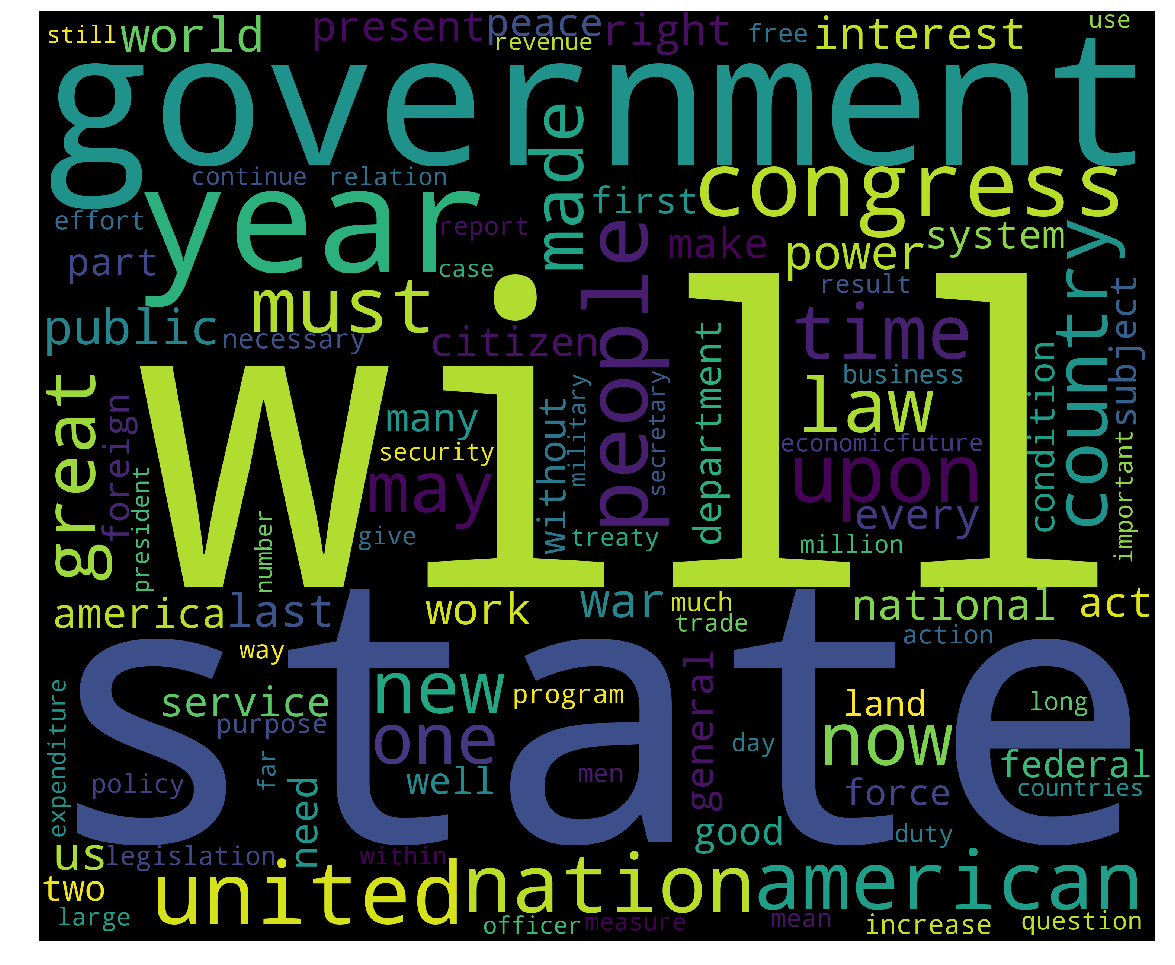

In [74]:
#WordCloud
from wordcloud import WordCloud, STOPWORDS

cleaned_text = ' '.join(list(df_new.text))

wordcloud = WordCloud(stopwords=STOPWORDS,max_words=100,
                      background_color='black',min_font_size=6,
                      width=3000,collocations=False,
                      height=2500
                     ).generate(cleaned_text)

plt.figure(1,figsize=(20, 20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Let's make a **word cloud** using our **tokens** (POS taggged and lemmatized).

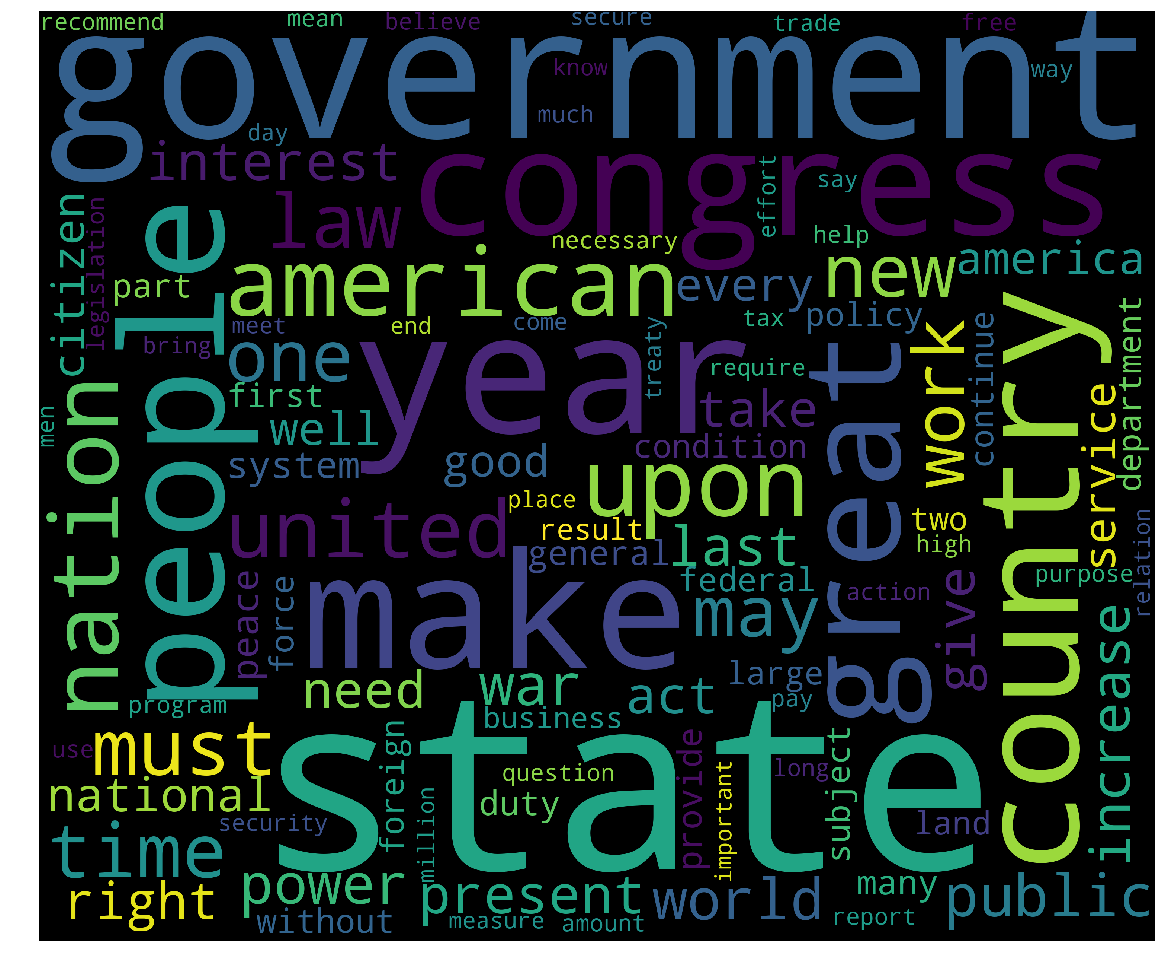

In [75]:
token_string = ''
for tokens in df_new.tokens:
    token_string += ' '.join(tokens) + ' '

wordcloud_tokens = WordCloud(stopwords=STOPWORDS,max_words=100,
                      background_color='black',min_font_size=6,
                      width=3000,collocations=False,
                      height=2500
                     ).generate(token_string)

plt.figure(1,figsize=(20, 20))
plt.imshow(wordcloud_tokens)
plt.axis('off')
plt.show()

# Topic Modeling

In [746]:
# Build a Dictionary - association word to numeric id
dictionary = corpora.Dictionary(df_new.tokens)

'''
We can "control" the level in which we extract topics from:
  * We can filter out tokens that show up in x% of all SOTU's, in effect
    uncovering more hidden topics (only present in (1-x)% of the SOTUs).
  * A similar strategy can be used to filter out very rare tokens by setting
    no_below
'''

#### FIRST SET OF HYPER-PARAMETERS

dictionary.filter_extremes(no_above=.15, no_below=3)

# Transform the collection of texts to a numerical form
corpus = [dictionary.doc2bow(text) for text in df_new.tokens]

NUM_TOPICS = 15

# Update the model to find more topics
lda_model = models.LdaModel(corpus=corpus, 
                            random_state=seed,
                            iterations=20,
                            num_topics=NUM_TOPICS, 
                            id2word=dictionary)

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator))

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator))

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator))

## Topic Visualization

In [747]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis


vis_data_lda = gensimvis.prepare(lda_model, corpus, dictionary)
#pyLDAvis.save_html(vis_data_lda,'lda_all.html')
pyLDAvis.display(vis_data_lda)

These topics all look pretty disjoint, although there is some overlap between topics 1, 3, 4 and 5. To get some more clarification on how individual words are related to each other (in the SOTU corpus), we can perform dimensionality reduction via truncated SVD on our bag of words matrix, and plot these 2 components. 

In [748]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

tokenized_docs = []
for tokens in df_new.tokens:
    ts = ' '.join(tokens)
    tokenized_docs.append(ts)
    


cv = CountVectorizer(stop_words='english', 
                     max_df=.15, 
                     min_df=3)
bow = cv.fit_transform(tokenized_docs).toarray()
 
# Build a Latent Dirichlet Allocation Model
lda_model2 = LatentDirichletAllocation(n_topics=NUM_TOPICS, max_iter=20, learning_method='online')
lda_Z = lda_model2.fit_transform(bow)

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [749]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
output_notebook()

svd = TruncatedSVD(n_components=2)
words_2d = svd.fit_transform(bow.T)
 
df = pd.DataFrame(columns=['x', 'y', 'word'])
df['x'], df['y'], df['word'] = words_2d[:,0], words_2d[:,1], cv.get_feature_names()
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

Loading BokehJS ...

**Note, you can zoom in/out of this plot.**

Now that we have extracted the top 10 most likely topics, we can apply them to each address separately.

In [750]:
lda_scores = [] #np.array((len(corpus), NUM_TOPICS))

for i in range(len(corpus)):
    y = lda_model[corpus[i]]
    #lda_scores.append([score[1] for score in y])
    lda_scores.append({score[0]:score[1] for score in y})

lda_df = pd.DataFrame(lda_scores)
lda_df.index = df_new.index
lda_df.fillna(0.0, inplace=True) # not sure about this...

lda_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
year,,,,,,,,,,,,,,,
1830,0.027829,0.235977,0.238634,0.015759,0.000000,0.164118,0.012694,0.028288,0.000000,0.097304,0.116564,0.000000,0.031402,0.000000,0.013375
1831,0.081124,0.564315,0.166335,0.086597,0.011394,0.027643,0.000000,0.000000,0.000000,0.000000,0.039397,0.012384,0.000000,0.000000,0.000000
1832,0.047535,0.265777,0.187953,0.048034,0.016767,0.000000,0.012360,0.056780,0.000000,0.108288,0.075279,0.000000,0.156534,0.000000,0.014466
1833,0.000000,0.118571,0.000000,0.189450,0.030407,0.000000,0.000000,0.379602,0.000000,0.033774,0.208938,0.000000,0.000000,0.032213,0.000000
1834,0.024798,0.117970,0.169803,0.231987,0.000000,0.027821,0.011059,0.014211,0.051028,0.142893,0.061942,0.000000,0.015119,0.014160,0.116972


Attach political party to lsi_scores to see if there is any major differences between the political parties.

In [752]:
lda_df.columns = ['topic_' + str(i) for i in range(NUM_TOPICS)]
lda_df['party'] = df_new.party
lda_df.groupby('party').mean()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
party,,,,,,,,,,,,,,,
Democratic,0.037058,0.127870,0.068070,0.047580,0.111515,0.048445,0.029851,0.051535,0.112546,0.049650,0.028899,0.079738,0.054673,0.067714,0.072145
Republican,0.022838,0.222905,0.015468,0.045199,0.061548,0.013802,0.067195,0.043889,0.169177,0.033827,0.038723,0.089252,0.057907,0.032600,0.070185


In [731]:
lda_df.groupby('party').var()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49
party,,,,,,,,,,,,,,,,,,,,,
Democratic,0.009982,0.003979,0.000013,0.001119,0.013193,0.000027,0.000005,0.010714,0.033165,0.001795,...,0.000347,0.031632,0.007732,0.00000,0.002115,0.017040,0.002264,0.007167,0.022045,0.000708
Republican,0.000396,0.026161,0.000228,0.001085,0.000476,0.000004,0.000434,0.003996,0.054536,0.000095,...,0.015446,0.010527,0.002329,0.00191,0.007884,0.000017,0.003396,0.011654,0.011829,0.000701


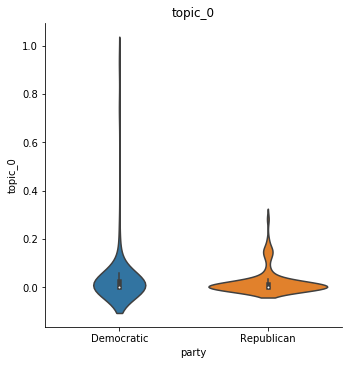

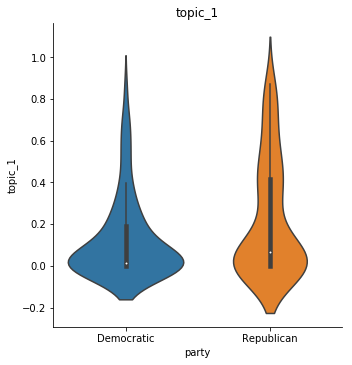

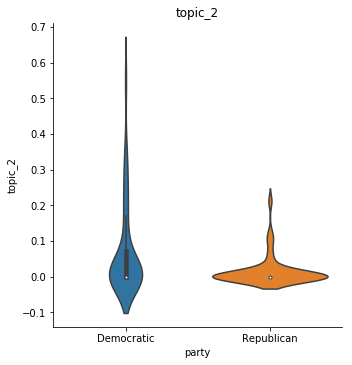

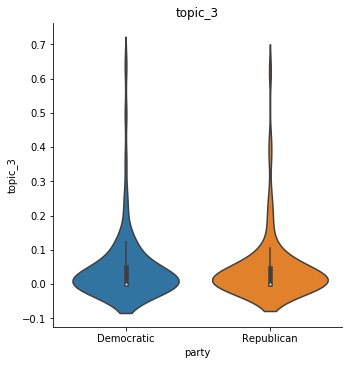

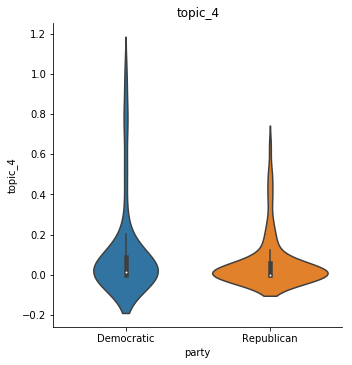

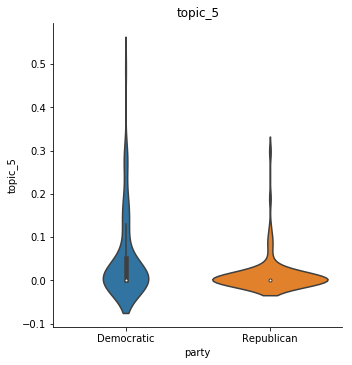

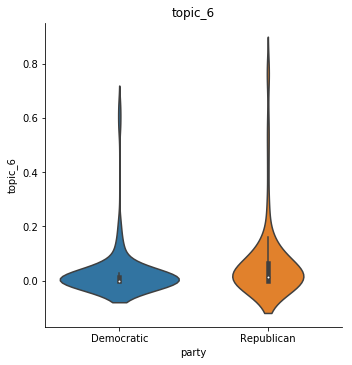

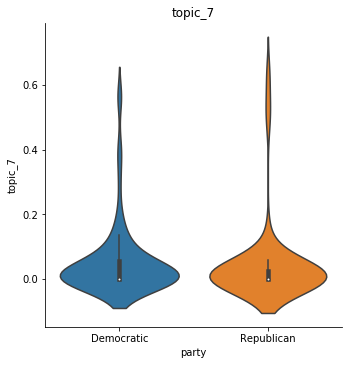

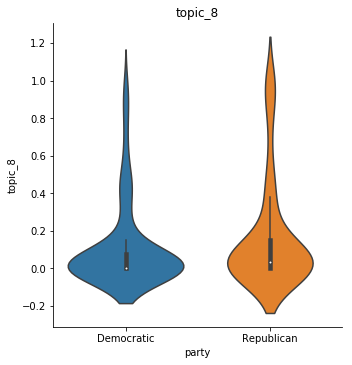

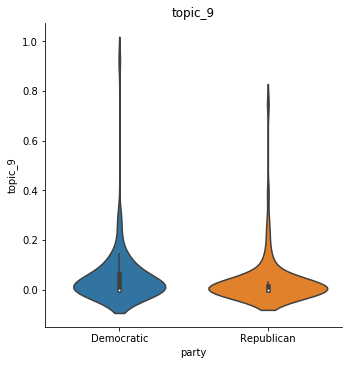

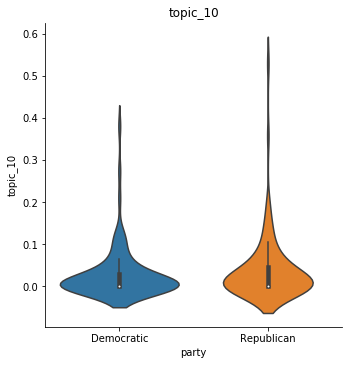

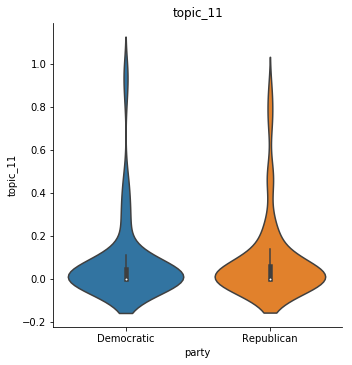

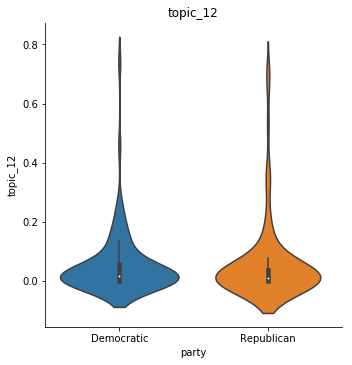

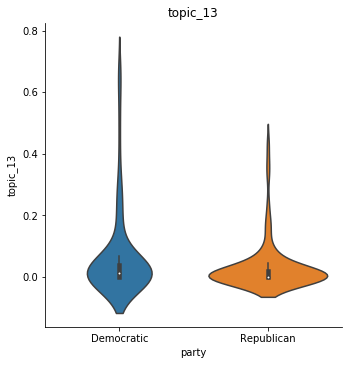

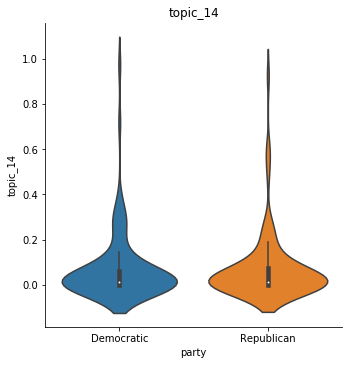

In [753]:
for i in range(NUM_TOPICS):
    curr_topic = 'topic_'+str(i)
    sns.catplot(x='party', y=curr_topic, kind='violin', data=lda_df)
    plt.title(curr_topic)

Now let us calculate the "running average" for a given topic: the average topic coverage (score) from year 0 (1830) up until year *i*, for all *i* in years.

In [809]:
rolling_avg = lda_df.copy()
window_size = 4 # years

for i in range(rolling_avg.shape[0]):
    for j in range(NUM_TOPICS):
        start = max(0, i-window_size)
        rolling_avg.iloc[i,j] = lda_df.iloc[start:i+1,j].mean()      

In [810]:
rolling_avg.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,party
year,,,,,,,,,,,,,,,,
1830,0.027829,0.235977,0.238634,0.015759,0.000000,0.164118,0.012694,0.028288,0.000000,0.097304,0.116564,0.000000,0.031402,0.000000,0.013375,Democratic
1831,0.054476,0.400146,0.202484,0.051178,0.005697,0.095880,0.006347,0.014144,0.000000,0.048652,0.077981,0.006192,0.015701,0.000000,0.006687,Democratic
1832,0.052163,0.355356,0.197641,0.050130,0.009387,0.063920,0.008351,0.028356,0.000000,0.068531,0.077080,0.004128,0.062645,0.000000,0.009280,Democratic
1833,0.039122,0.296160,0.148230,0.084960,0.014642,0.047940,0.006264,0.116167,0.000000,0.059841,0.110044,0.003096,0.046984,0.008053,0.006960,Democratic
1834,0.036257,0.260522,0.152545,0.114366,0.011714,0.043916,0.007223,0.095776,0.010206,0.076452,0.100424,0.002477,0.040611,0.009275,0.028963,Democratic


In [806]:
def plot_rolling_topic_coverage(topic_no, window_size = 4):
    
    g = sns.factorplot(x=rolling_avg.index, y='topic_'+str(topic_no), hue='party', kind='bar', data=rolling_avg)
    for ax in g.axes.flatten():
        ax.set_ylabel('Topic Coverage')
        ax.set_xticklabels('')
        ax.set_xticks([])
    plt.gcf().set_size_inches(20, 10)
    # Setting figure size ....(NEED HELP HERE in setting height of figure)

    fig = plt.gcf()
    # Setting the figure heading text ....(NEED HELP HERE with the text locations)
    
    title = "Topic {}, window size of {}".format(topic_no, window_size)
    fig.suptitle(title, fontsize=50, verticalalignment = "top", horizontalalignment = 'center')
    #fig.text(0.01,-0.05, lda_model.print_topic(topic_no, NUM_TOPICS), fontsize = 40)       
    plt.tight_layout()
    plt.show()
    print(lda_model.print_topic(topic_no, NUM_TOPICS))

In [760]:
sigma = lda_df.groupby('party').std()
sigma.iloc[0,:] / sigma.iloc[1,:]

topic_0     2.502538
topic_1     0.706846
topic_2     3.040676
topic_3     1.068674
topic_4     1.816244
topic_5     2.179482
topic_6     0.664393
topic_7     0.849768
topic_8     0.775037
topic_9     1.148594
topic_10    0.780672
topic_11    1.007322
topic_12    0.806790
topic_13    1.806536
topic_14    1.036647
dtype: float64

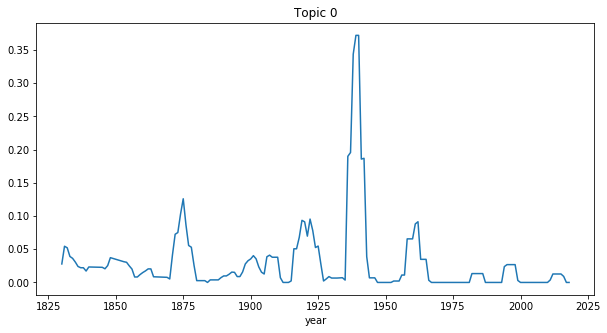

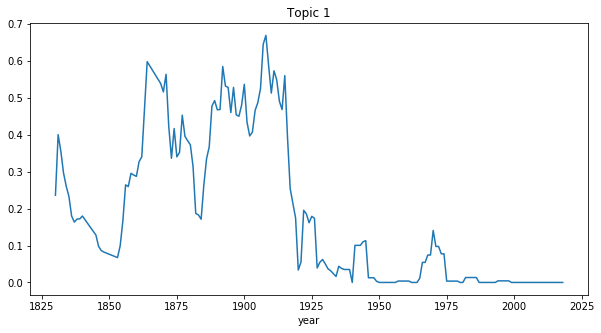

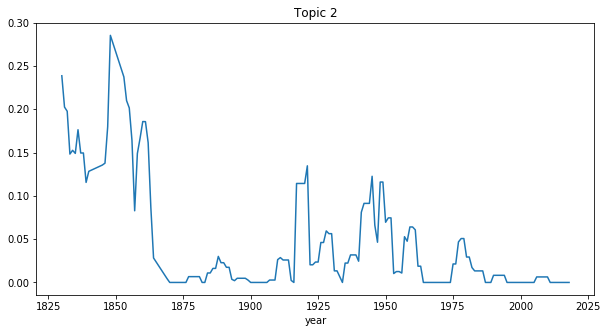

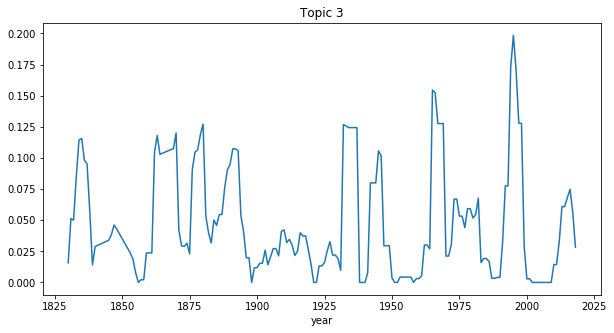

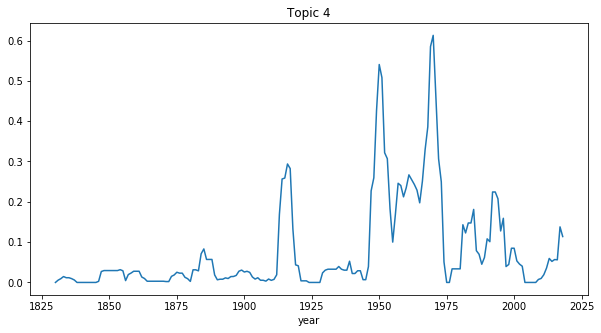

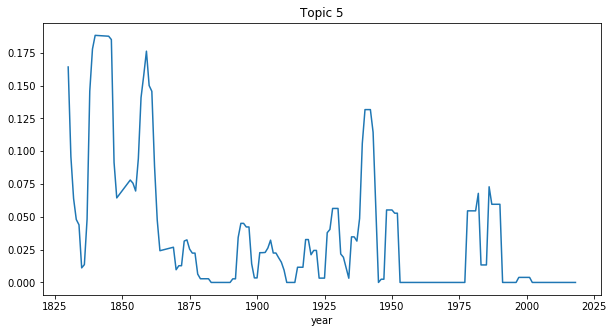

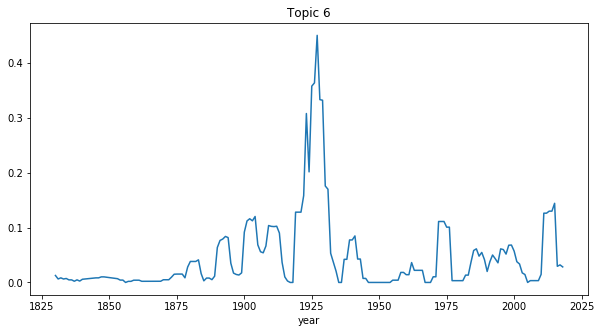

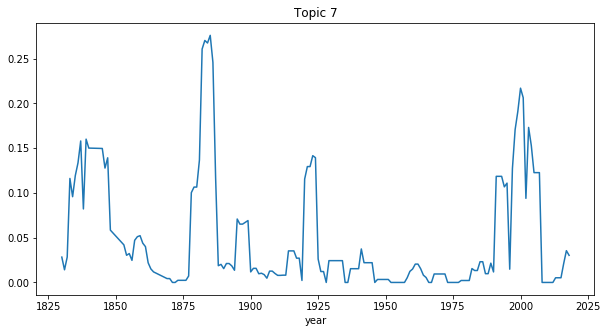

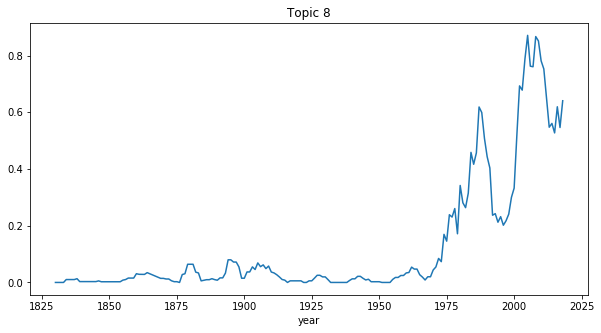

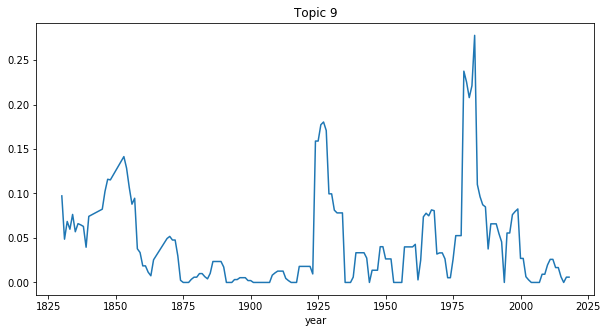

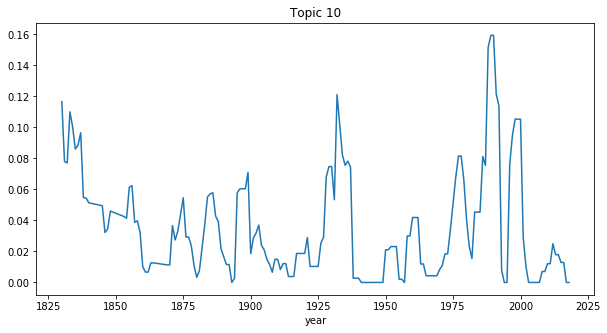

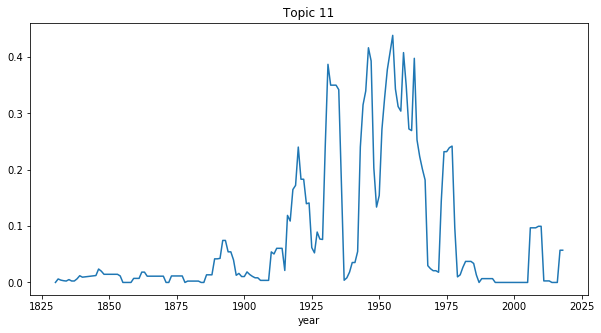

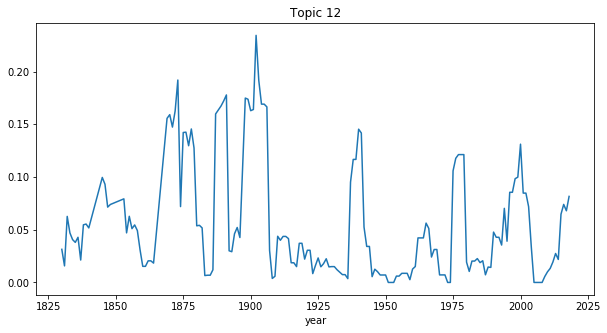

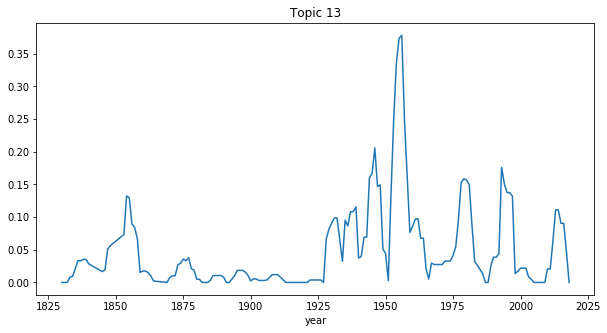

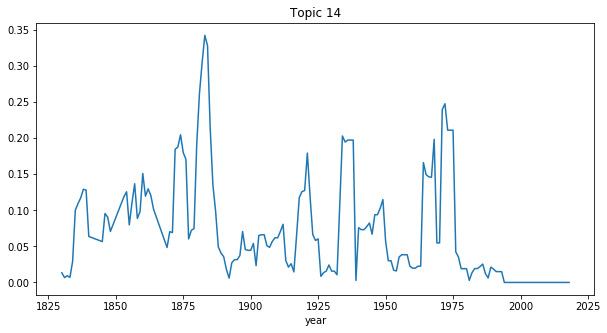

In [811]:
for i in range(NUM_TOPICS):
    plt.figure(figsize=(10,5))
    plt.title("Topic " + str(i))
    rolling_avg.iloc[:,i].plot()
    plt.show()

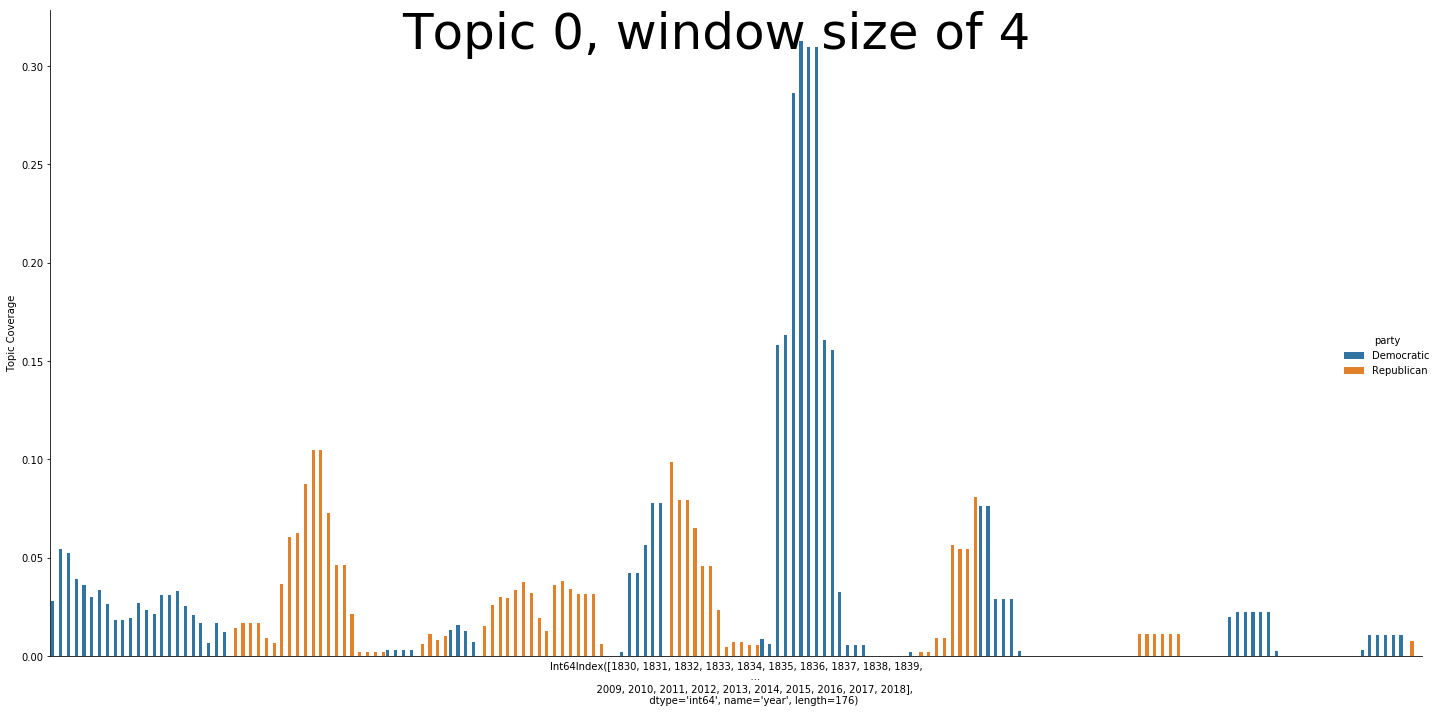

0.002*"communist" + 0.002*"terrorist" + 0.001*"iraq" + 0.001*"oregon" + 0.001*"atomic" + 0.001*"cable" + 0.001*"kid" + 0.001*"circuit" + 0.001*"isthmus" + 0.001*"coinage" + 0.001*"pound" + 0.001*"afghanistan" + 0.001*"decree" + 0.001*"regime" + 0.001*"ruler"


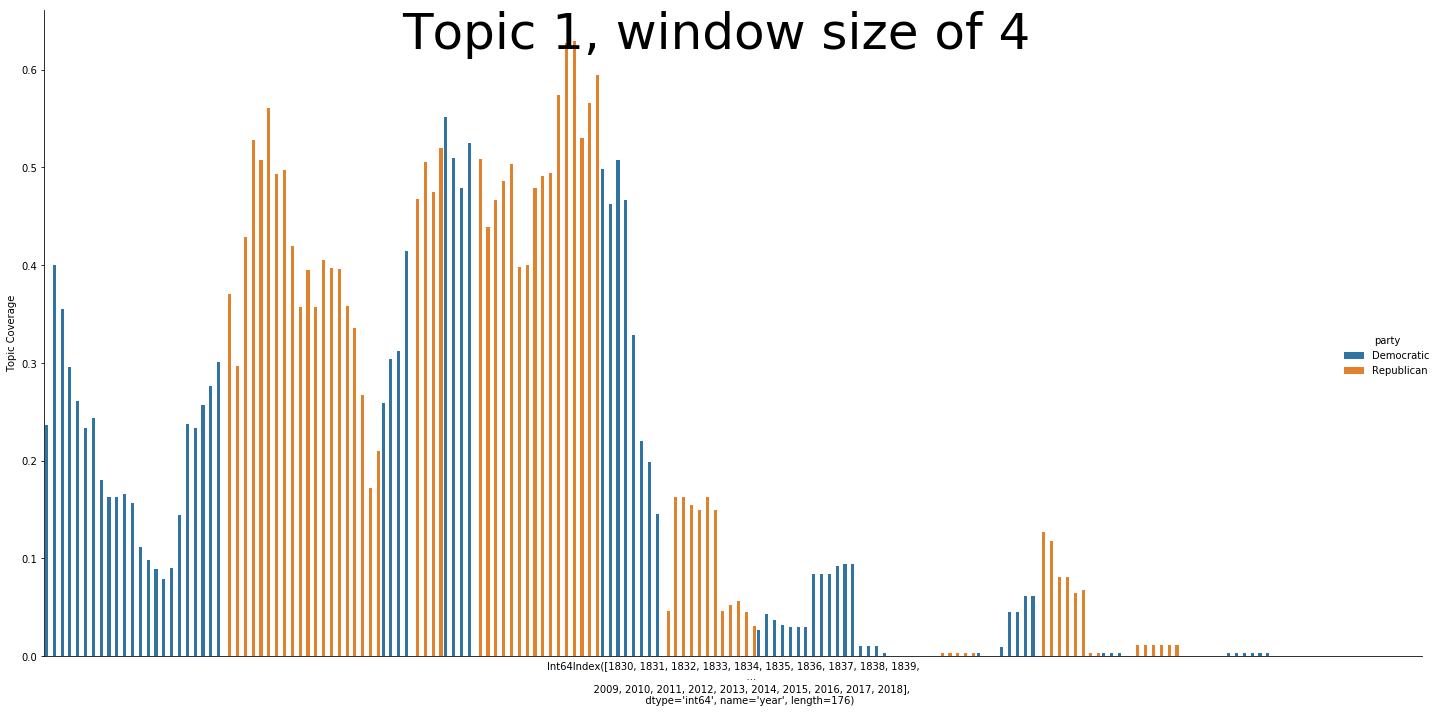

0.002*"pound" + 0.002*"isthmus" + 0.002*"coinage" + 0.001*"communist" + 0.001*"iraq" + 0.001*"vietnam" + 0.001*"terrorist" + 0.001*"whilst" + 0.001*"circuit" + 0.001*"cable" + 0.001*"seal" + 0.001*"wool" + 0.001*"improper" + 0.001*"torpedo" + 0.001*"oregon"


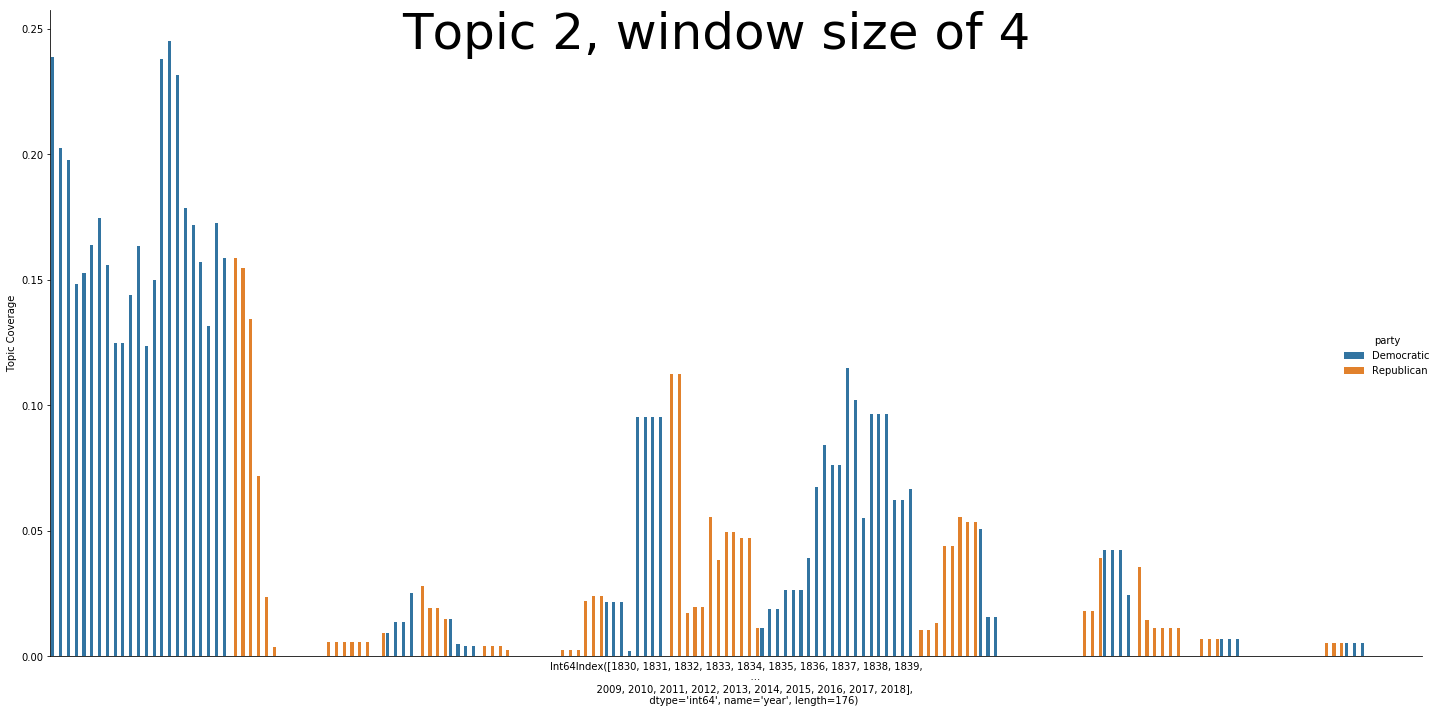

0.002*"iraq" + 0.002*"terrorist" + 0.001*"communist" + 0.001*"oregon" + 0.001*"coinage" + 0.001*"whilst" + 0.001*"atomic" + 0.001*"isthmus" + 0.001*"regime" + 0.001*"pound" + 0.001*"afghanistan" + 0.001*"kid" + 0.001*"commencement" + 0.001*"capability" + 0.001*"ruler"


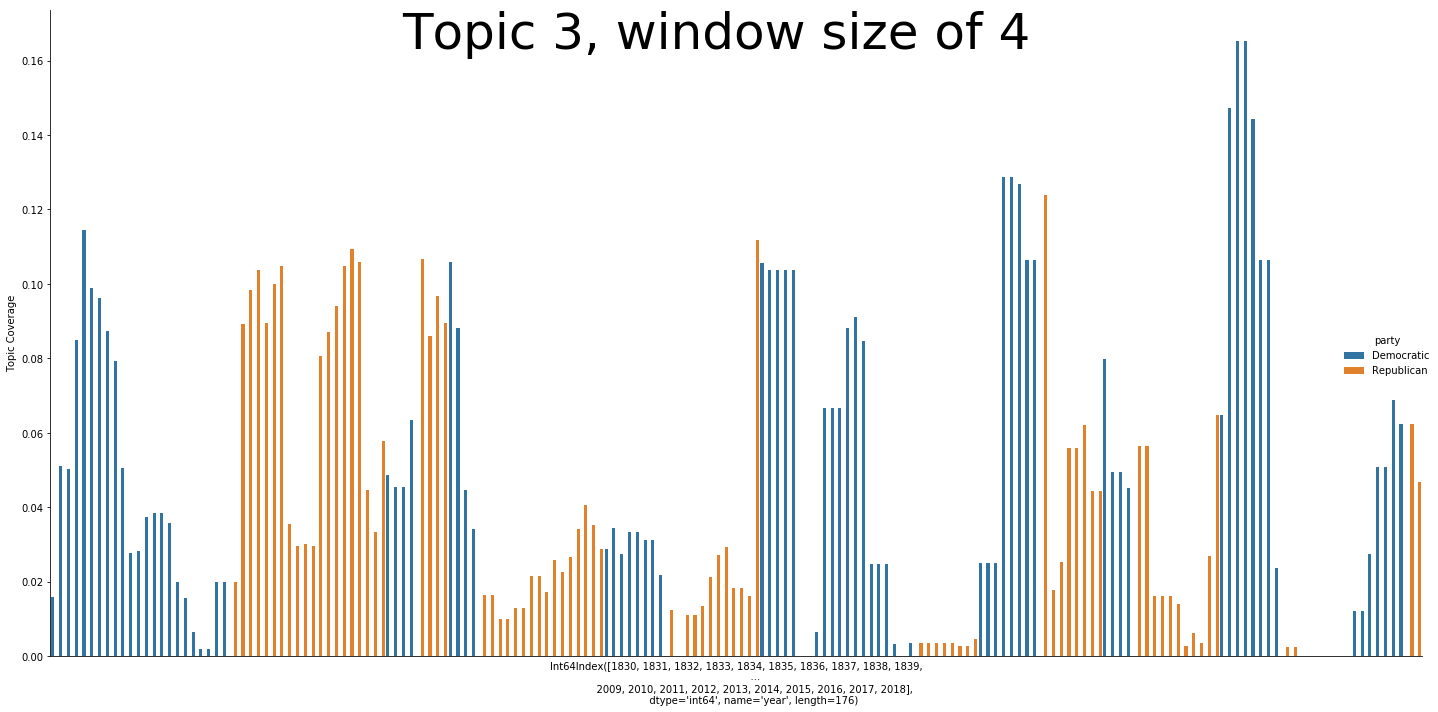

0.002*"communist" + 0.002*"terrorist" + 0.001*"coinage" + 0.001*"kid" + 0.001*"isthmus" + 0.001*"peacetime" + 0.001*"afghanistan" + 0.001*"iraq" + 0.001*"whilst" + 0.001*"plenipotentiary" + 0.001*"circuit" + 0.001*"vietnam" + 0.001*"collective" + 0.001*"procure" + 0.001*"atomic"


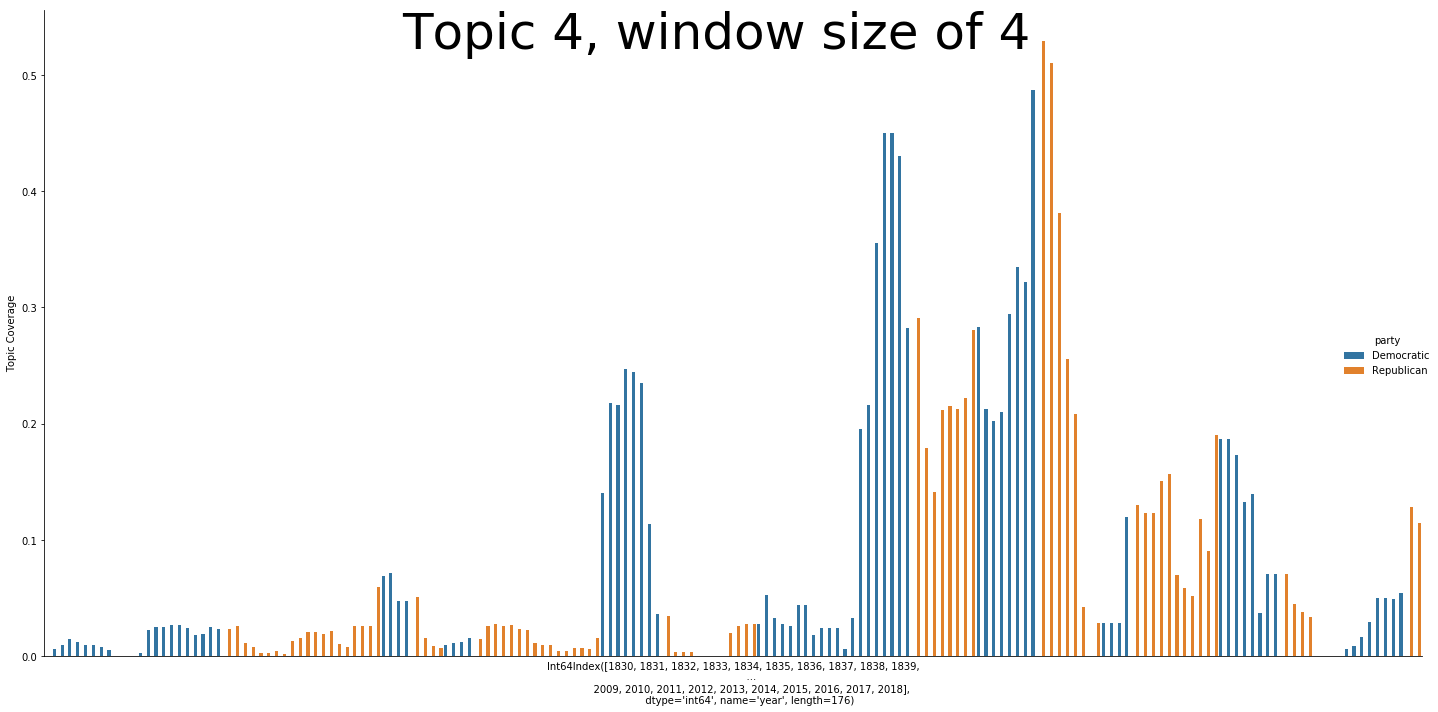

0.002*"vietnam" + 0.002*"communist" + 0.001*"atomic" + 0.001*"terrorist" + 0.001*"coinage" + 0.001*"cable" + 0.001*"isthmus" + 0.001*"collective" + 0.001*"afghanistan" + 0.001*"whilst" + 0.001*"iraq" + 0.001*"african" + 0.001*"kid" + 0.001*"low-income" + 0.001*"honduras"


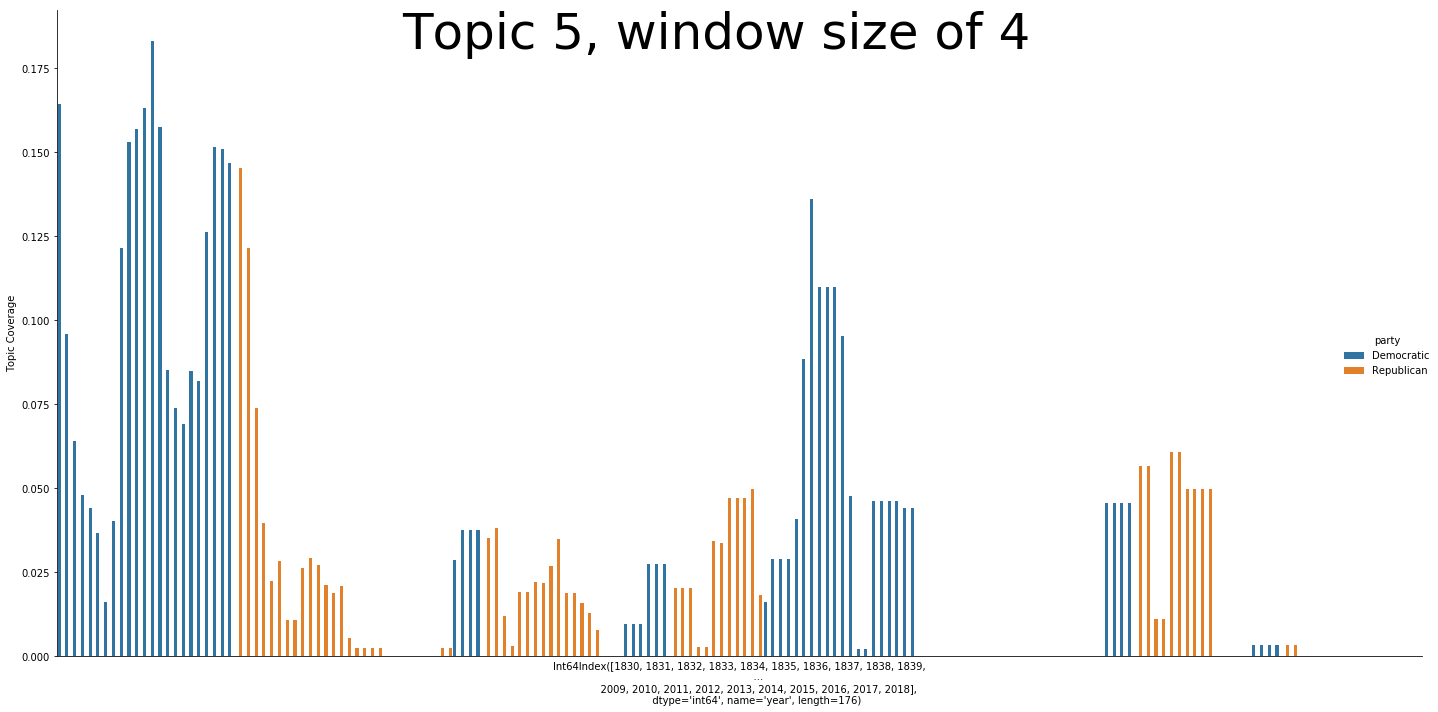

0.002*"isthmus" + 0.002*"communist" + 0.002*"iraq" + 0.001*"terrorist" + 0.001*"circuit" + 0.001*"whilst" + 0.001*"vietnam" + 0.001*"cable" + 0.001*"african" + 0.001*"kansas" + 0.001*"fashion" + 0.001*"coinage" + 0.001*"seal" + 0.001*"oregon" + 0.001*"peacetime"


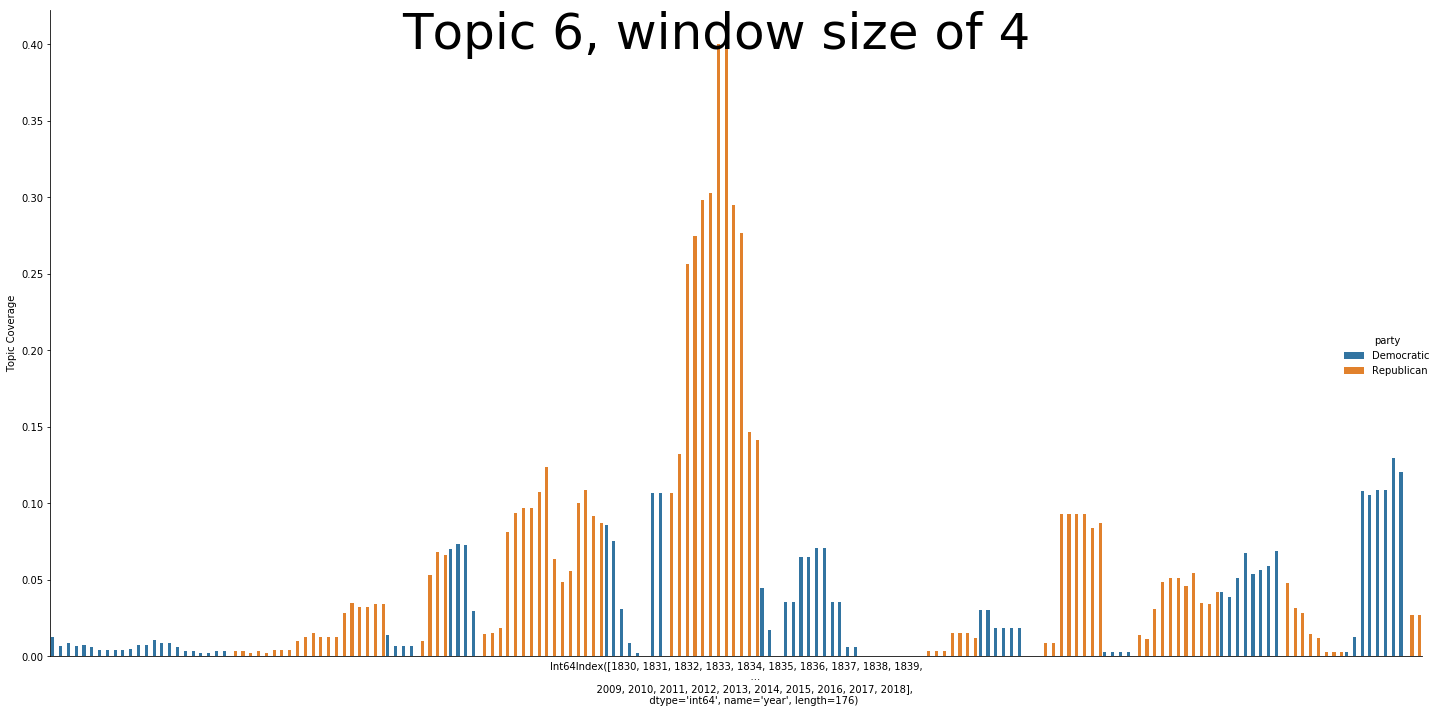

0.002*"terrorist" + 0.002*"iraq" + 0.001*"communist" + 0.001*"vietnam" + 0.001*"afghanistan" + 0.001*"cable" + 0.001*"coinage" + 0.001*"isthmus" + 0.001*"circuit" + 0.001*"seal" + 0.001*"oregon" + 0.001*"iraqi" + 0.001*"extradition" + 0.001*"whilst" + 0.001*"timber"


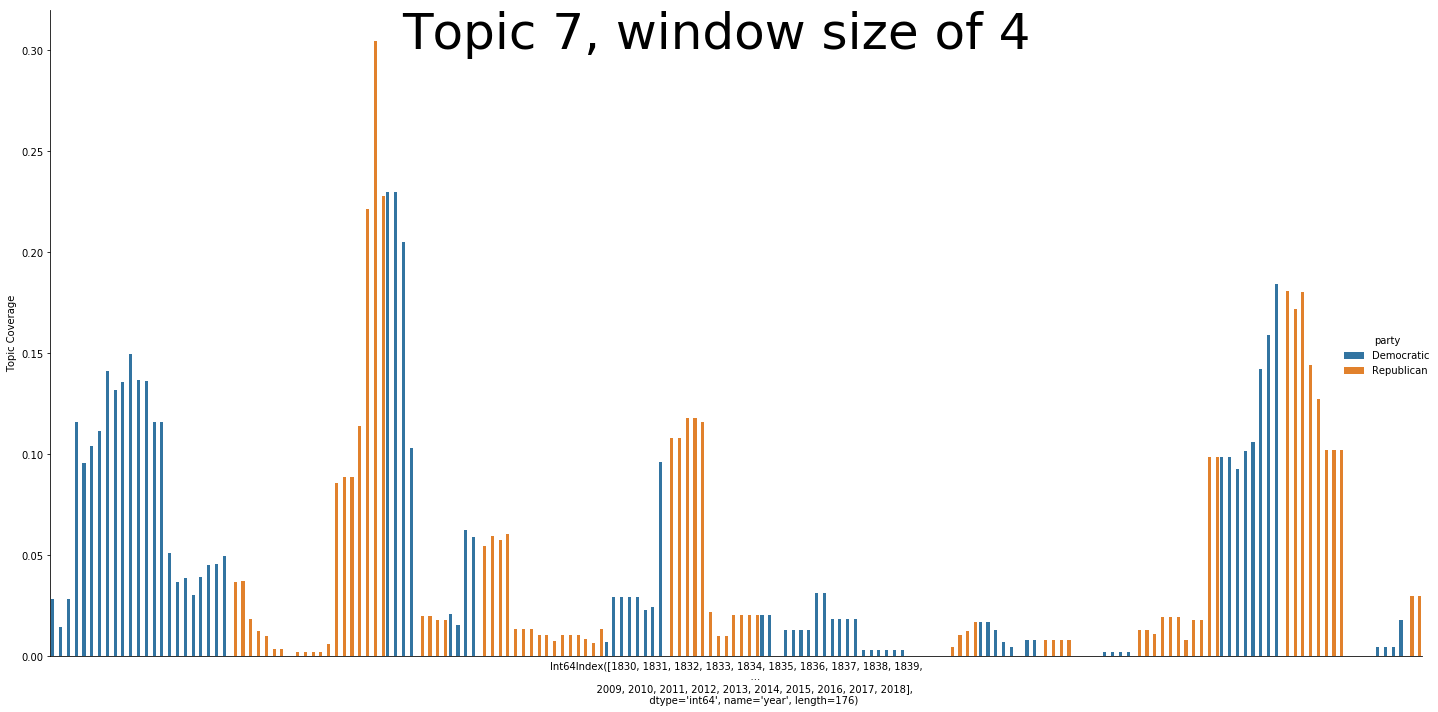

0.002*"iraq" + 0.002*"coinage" + 0.001*"terrorist" + 0.001*"kid" + 0.001*"isthmus" + 0.001*"iraqi" + 0.001*"affordable" + 0.001*"atomic" + 0.001*"collective" + 0.001*"whilst" + 0.001*"oregon" + 0.001*"saddam" + 0.001*"chemical" + 0.001*"communist" + 0.001*"peacetime"


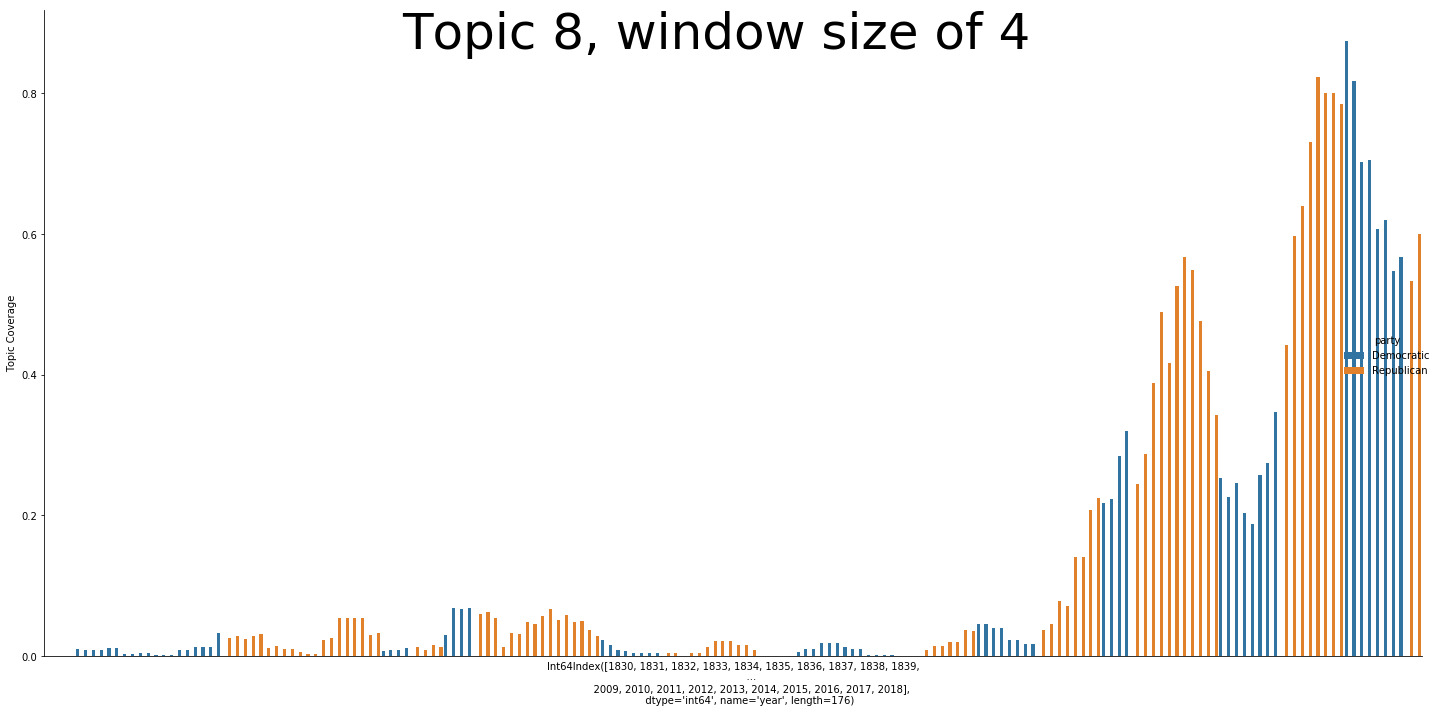

0.003*"terrorist" + 0.002*"iraq" + 0.002*"afghanistan" + 0.002*"isthmus" + 0.001*"coinage" + 0.001*"communist" + 0.001*"funding" + 0.001*"iraqi" + 0.001*"kid" + 0.001*"cable" + 0.001*"pound" + 0.001*"seal" + 0.001*"whilst" + 0.001*"timber" + 0.001*"oregon"


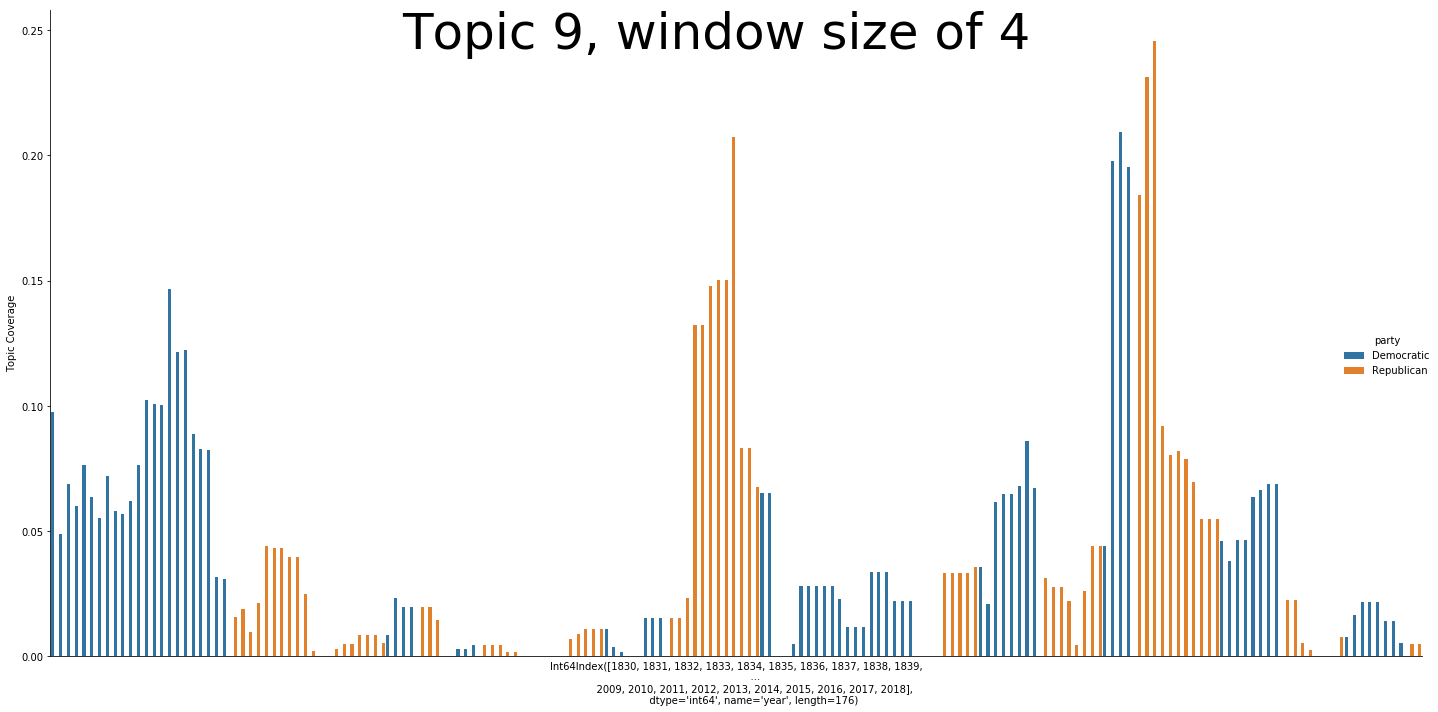

0.002*"iraq" + 0.001*"communist" + 0.001*"vietnam" + 0.001*"terrorist" + 0.001*"isthmus" + 0.001*"afghanistan" + 0.001*"capability" + 0.001*"cable" + 0.001*"whilst" + 0.001*"oregon" + 0.001*"annexation" + 0.001*"iraqi" + 0.001*"extradition" + 0.001*"coinage" + 0.001*"implement"


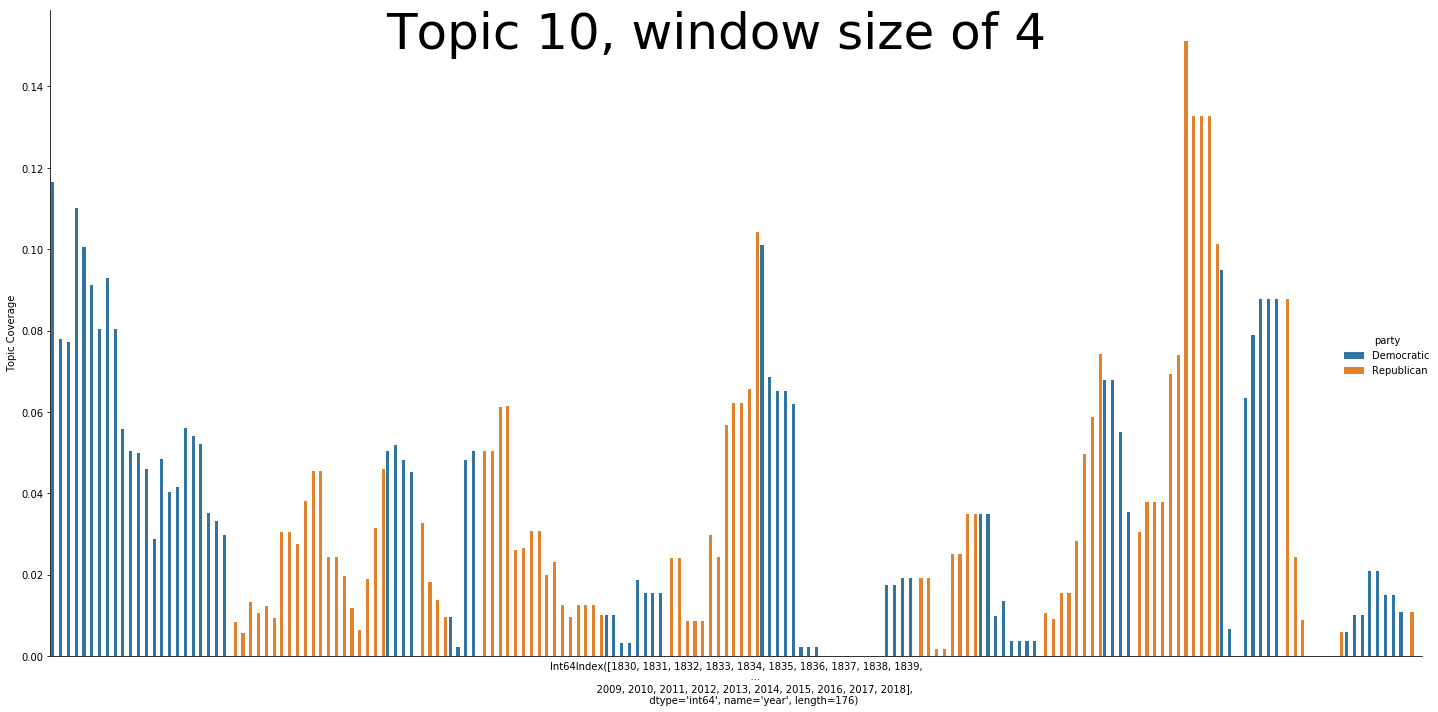

0.002*"terrorist" + 0.001*"isthmus" + 0.001*"iraq" + 0.001*"communist" + 0.001*"vietnam" + 0.001*"kid" + 0.001*"installment" + 0.001*"afghanistan" + 0.001*"pound" + 0.001*"iraqi" + 0.001*"coinage" + 0.001*"seal" + 0.001*"whilst" + 0.001*"cable" + 0.001*"steel"


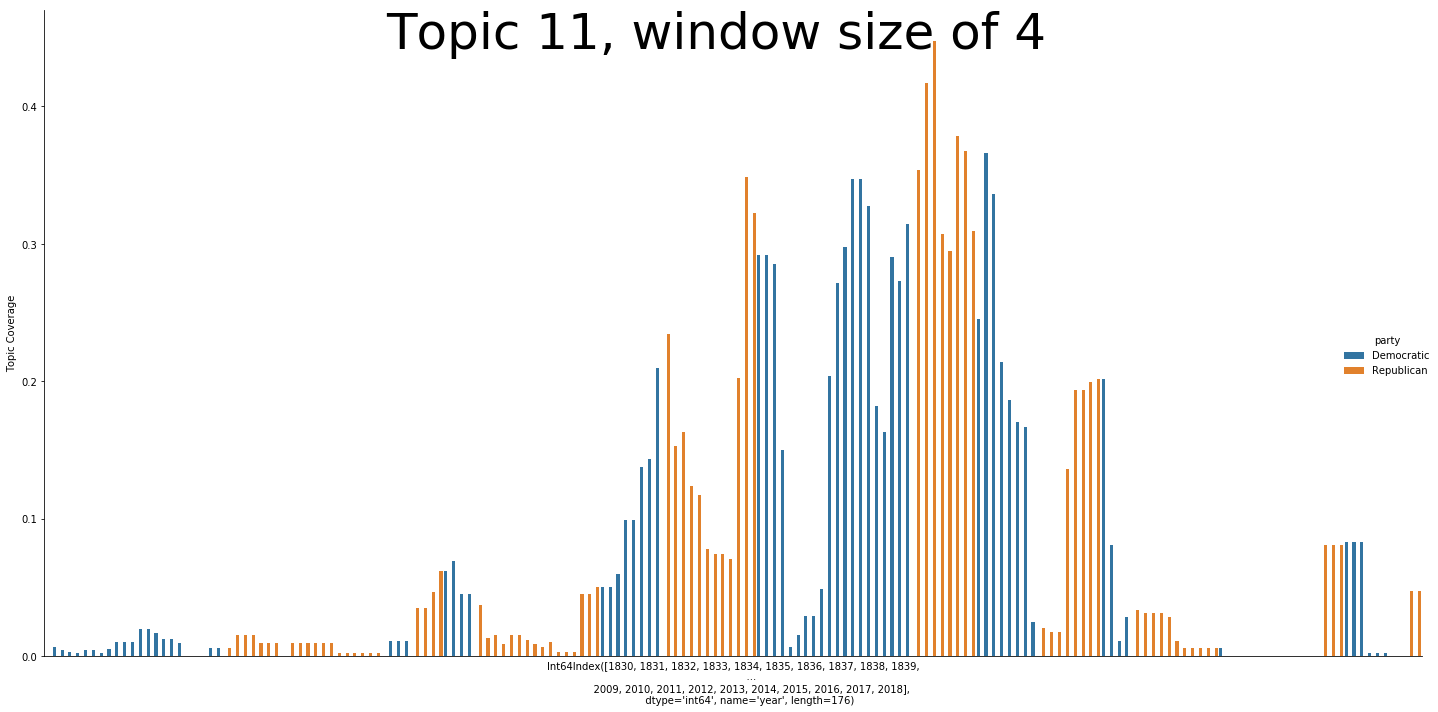

0.002*"communist" + 0.002*"terrorist" + 0.001*"iraq" + 0.001*"shortage" + 0.001*"plane" + 0.001*"afghanistan" + 0.001*"cable" + 0.001*"peacetime" + 0.001*"coinage" + 0.001*"collective" + 0.001*"vietnam" + 0.001*"atomic" + 0.001*"honduras" + 0.001*"whilst" + 0.001*"african"


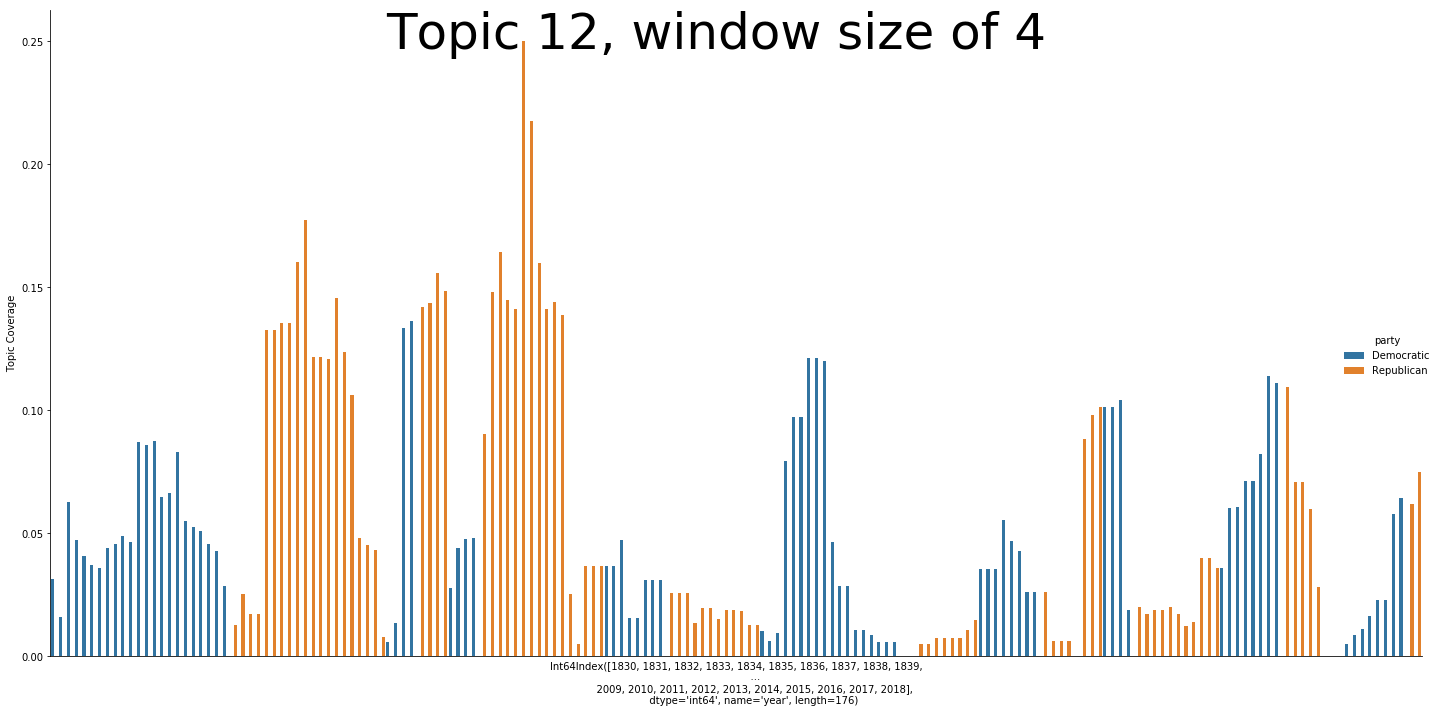

0.002*"terrorist" + 0.002*"cable" + 0.001*"isthmus" + 0.001*"communist" + 0.001*"iraq" + 0.001*"kid" + 0.001*"coinage" + 0.001*"oregon" + 0.001*"afghanistan" + 0.001*"seal" + 0.001*"honduras" + 0.001*"pound" + 0.001*"hague" + 0.001*"militia" + 0.001*"decree"


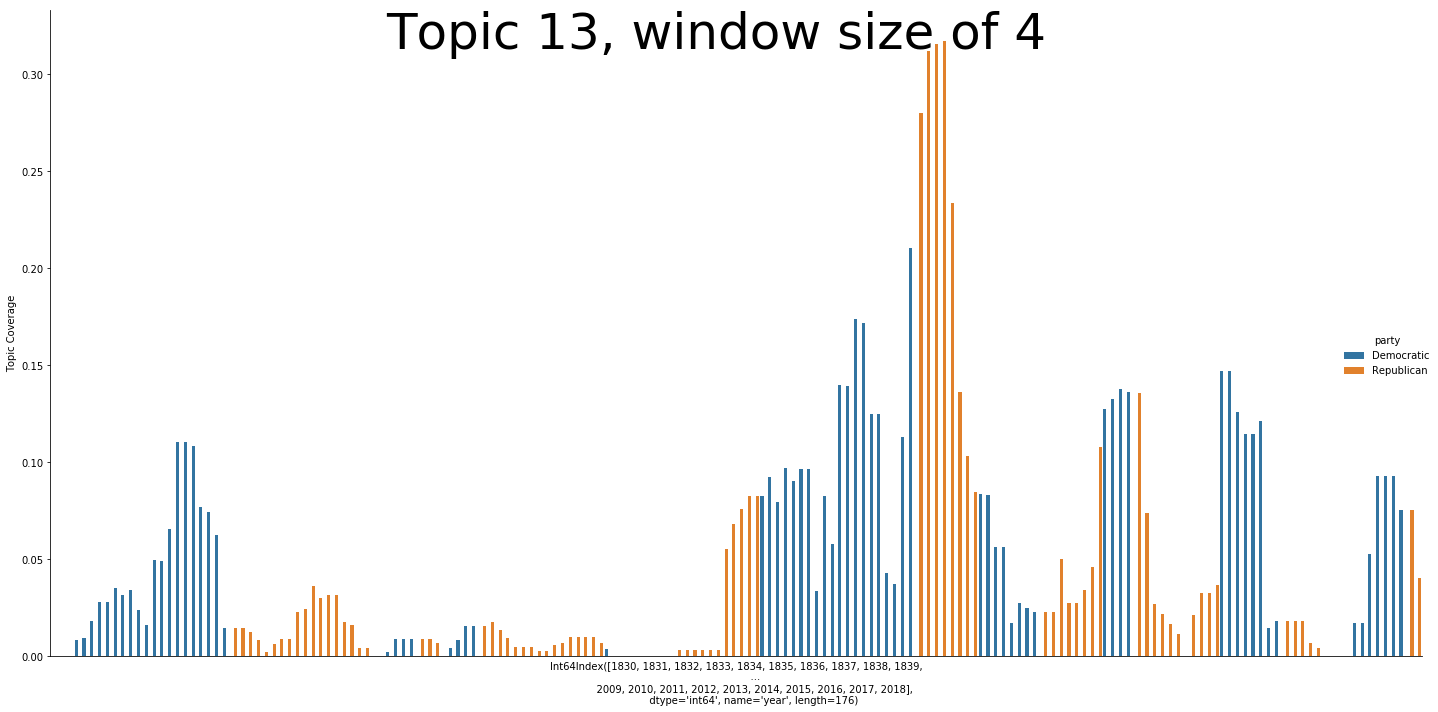

0.003*"communist" + 0.001*"whilst" + 0.001*"afghanistan" + 0.001*"terrorist" + 0.001*"coinage" + 0.001*"isthmus" + 0.001*"pound" + 0.001*"atomic" + 0.001*"iraq" + 0.001*"kid" + 0.001*"perceive" + 0.001*"ruler" + 0.001*"oregon" + 0.001*"collective" + 0.001*"vietnam"


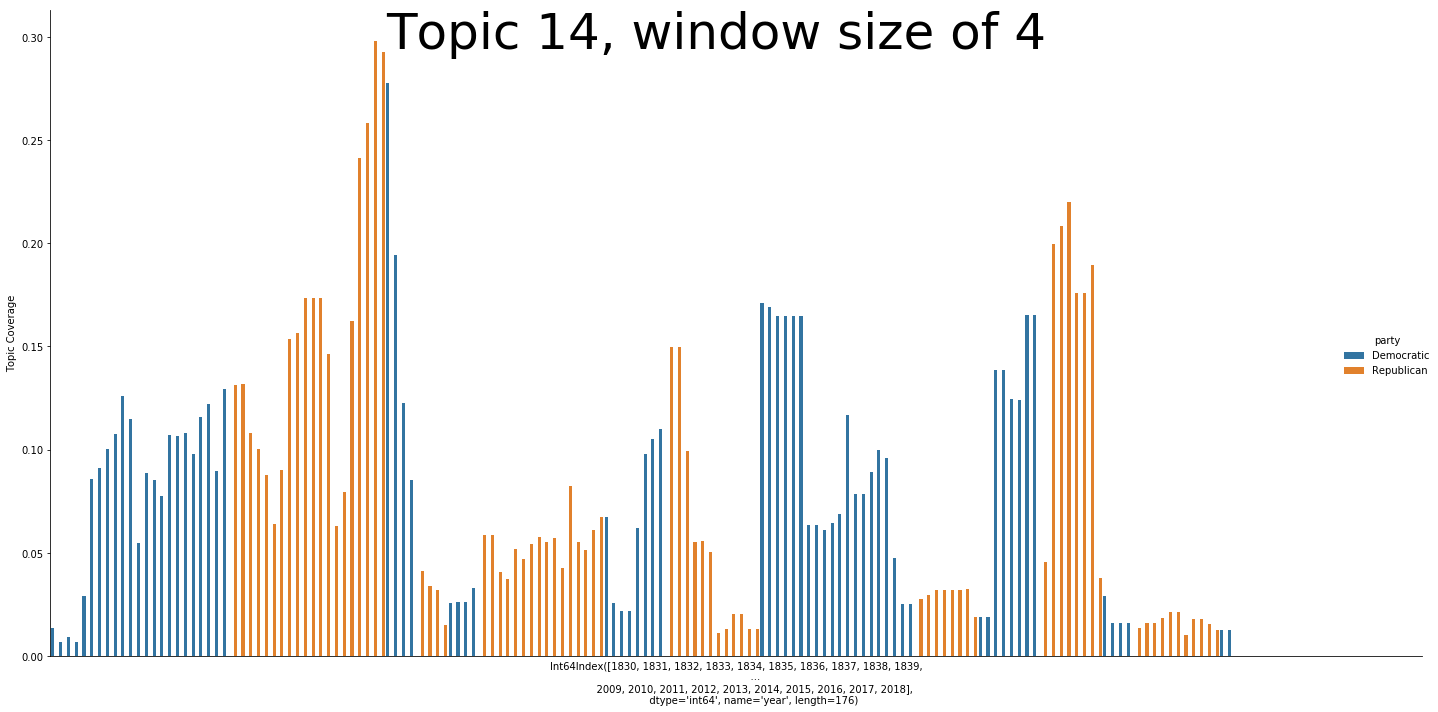

0.002*"isthmus" + 0.002*"communist" + 0.001*"peacetime" + 0.001*"pound" + 0.001*"nurse" + 0.001*"to-day" + 0.001*"seal" + 0.001*"coinage" + 0.001*"decree" + 0.001*"kansas" + 0.001*"terrorist" + 0.001*"whilst" + 0.001*"iraq" + 0.001*"cable" + 0.001*"wool"


In [808]:
for i in range(NUM_TOPICS):
    plot_rolling_topic_coverage(i)

In [804]:
lda_df.iloc[:,:10].sum().sort_values(ascending=False) / lda_df.shape[0]

topic_1    0.175927
topic_8    0.141183
topic_4    0.086248
topic_6    0.048735
topic_7    0.047669
topic_3    0.046376
topic_9    0.041649
topic_2    0.041470
topic_5    0.030927
topic_0    0.029867
dtype: float64

**Takeaway**:  
When the ball gets rolling, it maintains its' momentum (regardless of the political party in office). Once a topic is introduced, it gains coverage gradually, and is gradually phased out. Topic 8 has recently received a lot of coverage, and the trend I observed is that once a Republican takes office he gradually ramps up covering this topic, while Democrats tend to do the opposite. However, any change in coverage is not significantly different from the previous period. Topic 3 has relatively high coverage, regardless of party (is periodic with elections).

This tells me that Democrats are much more likely to discuss a new topic, and then after introducing this topic they tend to deviate quite a bit in future coverage. On the other side of the idle, Republicans are fairly consistent with their topic coverage, the only exception really being topic 8. Topic 8 appears to mostly be concerned with the war(s) in Iraq/Afghanistan and terrorism. This was, and still is, a very polarizing issue.  

The topics inferred by LDA are also representative of world events during that time, such as the peak observed in topic 0 coverage, which coincides with invention of the atomic bomb, communist Germany and World War II. Because most topics are pretty specific (like Vietnam or Iraq). I do not see one topic maintaining a relatively constant amount of coverage over the years. Therefore, most topics do not generalize well over time, and thus need to only use recent topics and a much larger corpus to be able to accurately classify text to political party.

In [818]:
# Build a Dictionary - association word to numeric id
dictionary = corpora.Dictionary(df_new.tokens)

'''
We can "control" the level in which we extract topics from:
  * We can filter out tokens that show up in x% of all SOTU's, in effect
    uncovering more hidden topics (only present in (1-x)% of the SOTUs).
  * A similar strategy can be used to filter out very rare tokens by setting
    no_below
'''

#### FIRST SET OF HYPER-PARAMETERS

dictionary.filter_extremes(no_above=.15, no_below=3)

# Transform the collection of texts to a numerical form
corpus = [dictionary.doc2bow(text) for text in df_new.tokens]

# Update the model to find more topics
lda_model = models.LdaModel(corpus=corpus, 
                            random_state=seed,
                            iterations=20,
                            num_topics=50, 
                            id2word=dictionary)

lda_scores = [] #np.array((len(corpus), NUM_TOPICS))

for i in range(len(corpus)):
    y = lda_model[corpus[i]]
    #lda_scores.append([score[1] for score in y])
    lda_scores.append({score[0]:score[1] for score in y})

lda_df = pd.DataFrame(lda_scores)
lda_df.index = df_new.index
lda_df.fillna(0.0, inplace=True) # not sure about this...

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator))

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator))

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator))

In [820]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.feature_selection import SelectKBest, chi2


X_new = SelectKBest(chi2, k=15).fit_transform(lda_df, df_new.party)

X_train, X_test, y_train, y_test = train_test_split(X_new, 
                                                    df_new.party, 
                                                    test_size=0.4, 
                                                    random_state=seed)
clf = SGDClassifier(random_state=seed)
clf.fit(X_train, y_train)
y_pred = cross_val_predict(clf, X_test, y_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Democratic       0.72      0.68      0.70        34
  Republican       0.72      0.76      0.74        37

   micro avg       0.72      0.72      0.72        71
   macro avg       0.72      0.72      0.72        71
weighted avg       0.72      0.72      0.72        71



# Conclusion  

Here I used LDA to extract the top 50 latent topics from all of the SOTU addresses, then calculated the topic scores for each address and used only these scores to predict which political party that text originated from. Essentially what I am attempting to show is that the different political parties stress certain topics over others and this information, alone, can be used to classify text. 

I used a stochastic gradient descent, linear classifier (with the default parameters) and achieved an accuracy of 72% (micro average, F1-score). There are a few things I took away from this: most topics inferred do not generalize well over time and thus a tighter window constraint must be set, Democrats are more likely to cover new topics, but deviate much more on which topics they discuss. Republicans behave a lot more predictably, and recently the topic concerning terrorism, Iraq, Afghanistan and funding have been covered widely by both parties. Topic modeling is an excellent way for information retrieval, however, it does not seem as promising (in isolation) for classification purposes. 